<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/SBER_1h_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

Задаем параметры, необходимые для подготовки dataset'a

In [ ]:
path_tickers = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/ins_OHLC'
path_outputs = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/SBER_MIN60/Up/outputs'
path_models = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/SBER_MIN60/Up/models'

os.chdir(path_tickers)
tickers_list = os.listdir()
print('Всего тикеров: ', len(tickers_list), '\n')
tickers_list[-1]

Всего тикеров:  21 



'SBER_MIN60.txt'

In [ ]:
step_in_the_last = 14   # По скольки шагам в прошлое определяем тренд     ##20,16,16,4
n_steps = 19             # Серию из скольки баров назад анализируем         ##44,42,48,6
forvard_lag = 1         # Предсказание какого бара в будущем делаем       ##1
plato_lvl = 0.00       # Какой разброс цены считать "плато" и приравнивать к 0 в ohe при разметке Y #0
test_lvl = .2             # Обьем выборки, уходящей в xTest
analyze_period = 30000    # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) #3000,2000,1000

### Загрузка и первичная обработка данных

In [ ]:
file = tickers_list[-1] 
file

'SBER_MIN60.txt'

In [ ]:
os.chdir(path_tickers)
# Загрузка только [Open, High, Low, Close]
data = pd.read_csv(file, sep="\t", header=None)
data.columns=['Data', 'Open', 'High', 'Low', 'Close']
#data = data[-500:] # взяли последние 500 баров, окторые откусили при обучении, чтобы их не видела нейронка
data

,Data,Open,High,Low,Close
0,2000-01-05 11:00:00.000,1.15000,1.17000,1.0800,1.125
1,2000-01-05 12:00:00.000,1.13500,1.17300,1.1350,1.168
2,2000-01-05 13:00:00.000,1.16500,1.23999,1.1650,1.200
3,2000-01-05 14:00:00.000,1.20000,1.25500,1.1980,1.255
4,2000-01-05 15:00:00.000,1.23001,1.26488,1.2115,1.264
...,...,...,...,...,...
43128,2019-12-30 14:00:00.000,253.05000,255.25000,252.9700,255.210
43129,2019-12-30 15:00:00.000,255.20000,256.00000,254.8600,255.160
43130,2019-12-30 16:00:00.000,255.16000,255.94000,254.5300,255.620
43131,2019-12-30 17:00:00.000,255.62000,255.65000,254.5500,254.810


In [ ]:
# Учим на 2018 годе
# data['2010-12-07 13:00' : '2010-12-07 13:01']
mask2018 = (data['Data'] >= '2010-09-01 10:00:00.000') & (data['Data'] <= '2018-12-31 23:59:00.000')
data = data[mask2018]
data

,Data,Open,High,Low,Close
22047,2010-09-01 10:00:00.000,78.55,78.67,77.94,78.04
22048,2010-09-01 11:00:00.000,78.04,78.10,77.60,78.00
22049,2010-09-01 12:00:00.000,78.00,78.88,77.98,78.88
22050,2010-09-01 13:00:00.000,78.89,79.19,78.80,78.85
22051,2010-09-01 14:00:00.000,78.85,78.99,78.61,78.86
...,...,...,...,...,...
40860,2018-12-29 14:00:00.000,186.07,186.08,185.78,185.88
40861,2018-12-29 15:00:00.000,185.88,185.95,185.70,185.70
40862,2018-12-29 16:00:00.000,185.70,186.15,185.70,186.15
40863,2018-12-29 17:00:00.000,186.15,186.35,186.00,186.02


In [ ]:
# тут я удаляю "не нужные" данные и переимновываю под привычные мне
# и под стандарт, в котором выдает данные сервис yahoo (на всякий случай)
df_data = data.drop(data.columns[[1, 2, 3]], axis='columns') # Оставляем дату и цену, чтобы потом добавить в outputs
del data['Data']

Я решил отказаться от идеи спрогнозировать цену.

Вместо этого я буду прогнозировать тренд и его изменение.

Для того, чтобы нейронка "увидела" наличие тренда, я расчитываю изменение цены по отношению к цене на step_in_the_last шагов назад

Пример: Close_chng_1, Close_chng_2, Close_chng_3 и тд показывают, на сколько цена n изменилась по отношению к цене n-1, n-2, n-3 и тд 

In [ ]:
# считаем относительную доходность единицах на step_in_the_last шагов назад
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах

data = data.dropna() # удаляем строки с NaN
print(data.shape)
data[-5:]

(18804, 18)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14
40860,186.07,186.08,185.78,185.88,-0.001075,0.000969,0.000215,-0.002790,-0.003324,-0.005191,-0.002147,-0.002362,-0.006042,-0.003111,-0.003164,-0.002415,0.002859,0.004757
40861,185.88,185.95,185.70,185.70,-0.000968,-0.002042,0.000000,-0.000753,-0.003755,-0.004290,-0.006155,-0.003114,-0.003328,-0.007005,-0.004076,-0.004129,-0.003381,0.001888
40862,185.70,186.15,185.70,186.15,0.002423,0.001453,0.000376,0.002423,0.001668,-0.001341,-0.001877,-0.003746,-0.000698,-0.000912,-0.004599,-0.001663,-0.001716,-0.000966
40863,186.15,186.35,186.00,186.02,-0.000698,0.001723,0.000753,-0.000322,0.001723,0.000969,-0.002039,-0.002574,-0.004442,-0.001396,-0.001610,-0.005294,-0.002360,-0.002413
40864,186.05,186.49,185.97,186.34,0.001720,0.001021,0.003446,0.002475,0.001397,0.003446,0.002690,-0.000322,-0.000858,-0.002729,0.000322,0.000107,-0.003583,-0.000644


Text(0.5, 1.0, 'График изменений цены на SBER 2019 - 2020 (1h), за 14 дня(дней) назад')

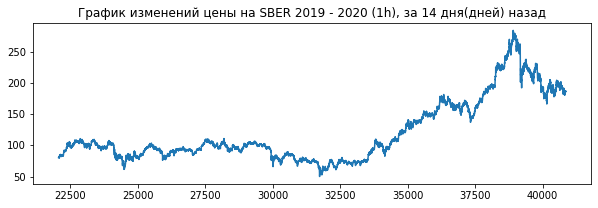

In [ ]:
plt.figure(figsize=(10,4))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
#ax1 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
data['Close'].plot(ax = ax0)
plt.title('График изменений цены на SBER 2019 - 2020 (1h), за %d дня(дней) назад' % (step_in_the_last))
#data[indicator_name].plot(ax = ax1)

In [ ]:
# Добавил разметку как в Y но сдвинул на тренд
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data[indicator_name_new] = 0
  #data.loc[data[indicator_name] < (0 - plato_lvl), indicator_name_new] = -1
  data.loc[data[indicator_name] > (0 + plato_lvl), indicator_name_new] = 1

print(data.shape)
data[-5:]

(18804, 32)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
40860,186.07,186.08,185.78,185.88,-0.001075,0.000969,0.000215,-0.002790,-0.003324,-0.005191,-0.002147,-0.002362,-0.006042,-0.003111,-0.003164,-0.002415,0.002859,0.004757,0,1,1,0,0,0,0,0,0,0,0,0,1,1
40861,185.88,185.95,185.70,185.70,-0.000968,-0.002042,0.000000,-0.000753,-0.003755,-0.004290,-0.006155,-0.003114,-0.003328,-0.007005,-0.004076,-0.004129,-0.003381,0.001888,0,0,0,0,0,0,0,0,0,0,0,0,0,1
40862,185.70,186.15,185.70,186.15,0.002423,0.001453,0.000376,0.002423,0.001668,-0.001341,-0.001877,-0.003746,-0.000698,-0.000912,-0.004599,-0.001663,-0.001716,-0.000966,1,1,1,1,1,0,0,0,0,0,0,0,0,0
40863,186.15,186.35,186.00,186.02,-0.000698,0.001723,0.000753,-0.000322,0.001723,0.000969,-0.002039,-0.002574,-0.004442,-0.001396,-0.001610,-0.005294,-0.002360,-0.002413,0,1,1,0,1,1,0,0,0,0,0,0,0,0
40864,186.05,186.49,185.97,186.34,0.001720,0.001021,0.003446,0.002475,0.001397,0.003446,0.002690,-0.000322,-0.000858,-0.002729,0.000322,0.000107,-0.003583,-0.000644,1,1,1,1,1,1,1,0,0,0,1,1,0,0


### Вычисление направления движения Close как ohe

In [ ]:
# Маркируем направление движения
indicator_name = 'Close_chng_%d' % (step_in_the_last)

a = data[data[indicator_name] < -plato_lvl]
a.loc[:, indicator_name] = 0
a.rename(columns = {indicator_name: 'Down'}, inplace=True)

b = data[data[indicator_name] >= -plato_lvl]
b.loc[:, indicator_name] = 0.
b.rename(columns = {indicator_name: 'Stay'}, inplace=True)

c = data[data[indicator_name] > plato_lvl]
c.loc[:, indicator_name] = 1.
c.rename(columns = {indicator_name: 'Up'}, inplace=True)

In [ ]:
data_UpDown = pd.concat([a['Down'], b['Stay'], c['Up']], axis=1)
data_UpDown = data_UpDown.fillna(0)
data_UpDown['Y'] = data_UpDown['Down'] + data_UpDown['Stay'] + data_UpDown['Up']
print(data_UpDown.shape)
data_UpDown[-10:]

#del data[indicator_name]

(18804, 4)


,Down,Stay,Up,Y
40855,0.0,0.0,1.0,1.0
40856,0.0,0.0,1.0,1.0
40857,0.0,0.0,1.0,1.0
40858,0.0,0.0,1.0,1.0
40859,0.0,0.0,1.0,1.0
40860,0.0,0.0,1.0,1.0
40861,0.0,0.0,1.0,1.0
40862,0.0,0.0,0.0,0.0
40863,0.0,0.0,0.0,0.0
40864,0.0,0.0,0.0,0.0


In [ ]:
# удаляю лишнее
del data_UpDown['Down'], data_UpDown['Stay'], data_UpDown['Up']
print(data_UpDown.shape)
data_UpDown[-10:]

(18804, 1)


,Y
40855,1.0
40856,1.0
40857,1.0
40858,1.0
40859,1.0
40860,1.0
40861,1.0
40862,0.0
40863,0.0
40864,0.0


In [ ]:
# превожу в to_categorical
from keras.utils import to_categorical
categorical_labels = to_categorical(data_UpDown, num_classes = 2)
print(len(categorical_labels))
categorical_labels[-10:]

18804


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Делим на обучающую, тестовую и валидационную выборки

In [ ]:
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  del data[indicator_name]

del data['Open'], data['High'], data['Low']

print(data.shape)
data[-5:]

(18804, 15)


,Close,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
40860,185.88,0,1,1,0,0,0,0,0,0,0,0,0,1,1
40861,185.70,0,0,0,0,0,0,0,0,0,0,0,0,0,1
40862,186.15,1,1,1,1,1,0,0,0,0,0,0,0,0,0
40863,186.02,0,1,1,0,1,1,0,0,0,0,0,0,0,0
40864,186.34,1,1,1,1,1,1,1,0,0,0,1,1,0,0


### Деление на выборки train, test, val

In [ ]:
data = data.values
print(data.shape, type(data))

(18804, 15) <class 'numpy.ndarray'>


In [ ]:
# берем для xTest последние 20% значений, но кратно n_steps
#n_train = int(len(data)*test_lvl//n_steps*n_steps) #  то, что уходит в train 
n_train = 600
xTrain = data[:-n_train]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train]
yTest = categorical_labels[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (18204, 15) 	yTrain: (18204, 2) 
xTest:   (600, 15) 	yTest:  (600, 2)


18804

In [ ]:
data[-n_train:][-1] # последняя подаваемая строка

array([186.34,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ])

### Скалирование Х

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все
""" 
# Масштабируем только X
"""
#xScaler = StandardScaler()
xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(18204, 15) (600, 15) <class 'numpy.ndarray'>


array([[ 1.42205261,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -1.        , -1.        ,
        -1.        ,  0.        ,  0.        , -1.        , -1.        ]])

In [ ]:
# проверяю обратную трансформацию
x = xScaler.inverse_transform(xTest[-1:])
x[-1][0]

186.34

### Превращение в TimeSeries

In [ ]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# n_steps = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, n_steps, forvard_lag):
  # sequence = df.values - это массив из данных
  # n_steps = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return array(X), array(y)

In [ ]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
# Формируем выборки для обучения нейросети
xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (18185, 19, 15) (18185, 2)


In [ ]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
# Формируем выборки для обучения нейросети
xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTest и yTest:	 (581, 19, 15) (581, 2)


In [ ]:
#from sklearn.model_selection import train_test_split
#xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, shuffle=False) # эксперимент с True
#print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
#      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)

In [ ]:
close = xScaler.inverse_transform(xTest[-1])
#close[-1][3], yTest[-1]
close[-1][0], yTest[-1]

(186.02, array([1., 0.], dtype=float32))

In [ ]:
close = xScaler.inverse_transform(xTest[-2])
#close[-1][3], yTest[-2]
close[-1][0], yTest[-2]

(186.15, array([1., 0.], dtype=float32))

# Нейросети

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU, Embedding)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

In [ ]:
# Гиперпараметры
drop = 0.2

###Conv1D

In [ ]:
# -----------------------------
# Conv1D = создаем модель
# -----------------------------

# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
  
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
  #x = Dense(yTrain.shape[1], activation='softmax', dtype='float32')(x)
x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

  #print(model.summary()) #Вывод структуры модели
  #plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)


In [ ]:
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

#x = LSTM(100, dropout=drop)(input)
#x = RepeatVector(4)(x)
#x = LSTM(100, dropout=drop)(x)

#x = RepeatVector(4)(x)
#x = Conv1D(n_steps*10, 10, padding='same', activation='relu')(x)
#x = MaxPooling1D(pool_size=4)(x)

#x = LSTM(100, dropout=drop)(x)
#x = RepeatVector(4)(x)
#x = LSTM(100, dropout=drop)(x)

#x = RepeatVector(4)(x)
#x = Conv1D(n_steps*10, 10, padding='same', activation='relu')(x)

#x = Flatten()(x)
#x = Dense(n_steps*100, activation='relu')(x)
#x = Dropout(drop)(x)
#x = Dense(yTrain.shape[1], activation='softmax')(x)

#model = Model(input, x)

#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
#x = Flatten()(input)
#x = RepeatVector(4)(x)
#x = Conv1D(n_steps*2, 5, padding='same')(x) #relu, selu, softplus !!
#x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
#x = MaxPooling1D(pool_size=2)(x)
#x = LeakyReLU(alpha=0.1)(x)

#x = Flatten()(x)
#x = RepeatVector(4)(x)
#x = Conv1D(n_steps, 5, padding='same')(x)
#x = LeakyReLU(alpha=0.1)(x)
#x = MaxPooling1D(pool_size=2)(x)
#x = LeakyReLU(alpha=0.1)(x)

#x = Flatten()(x)
#x = Dense(n_steps*100)(x)
#x = LeakyReLU(alpha=0.1)(x)
#x = Dropout(drop)(x)
#x = Dense(yTrain.shape[1], activation='sigmoid')(x)

#model = Model(input, x)

#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

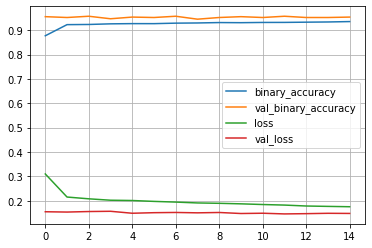

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 5e-05),
              #loss='categorical_crossentropy',
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) 

os.chdir(path_models)
# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint('_SBER_Conv_1h_Up.h5', monitor='val_binary_accuracy', verbose = 0,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
os.chdir(path_models)
model = load_model('_SBER_Conv_1h_Up.h5')

# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-200:]
y_test_org = yTest[-200:]
conv_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    conv_test.append('True')
  else:
    conv_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

clear_output()
from collections import Counter
accuracyConv = Counter(conv_test)
print(accuracyConv)

Counter({'True': 191, 'False': 9})


###Dense

In [ ]:
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Flatten()(input)
x = Dense(n_steps*500, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)

#x = RepeatVector(2)(x)
#x = LSTM(120, dropout=drop)(x)
#x = Dense(n_steps, activation='relu')(x)

x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

#print(model.summary())

In [ ]:
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
#x = Flatten()(input)
#x = Dense(n_steps*100)(x)
#x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
#x = Dropout(drop)(x)

#x = Dense(yTrain.shape[1], activation='sigmoid')(x)
#model = Model(input, x)

#print(model.summary())

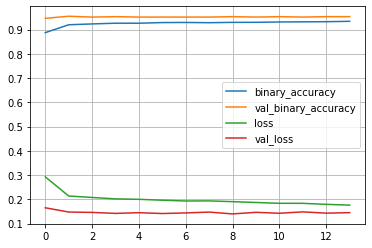

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-05),
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_Dense_1h_Up.h5', monitor='val_binary_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 0,
                    validation_data = (xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
os.chdir(path_models)
model = load_model('_SBER_Dense_1h_Up.h5')

n = 200 # сколько данных с конца берем для проверки
# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-n:]
y_test_org = yTest[-n:]
dense_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    dense_test.append('True')
  else:
    dense_test.append('False')

  print('Index:', i, '\tPrediction:', '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyDense = Counter(dense_test)
print(accuracyDense)

Counter({'True': 189, 'False': 11})


###GRU



In [ ]:
drop = 0.2
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения (n_steps)
# xTrain.shape[2] - число столбцов в обучающей выборке
x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop)(input)
#x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop, go_backwards=True)(input)
#x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop, return_sequences=True)(input)
x = RepeatVector(xTrain.shape[1])(x)
x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop)(x)

x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

#print(model.summary())

In [ ]:
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
#x = LSTM(n_steps*9, dropout=drop)(input)

#x = RepeatVector(9)(x)
#x = LSTM(n_steps*9, dropout=drop)(x)

#x = Dense(n_steps*10, activation='relu')(x)
#x = Dropout(drop)(x)

#x = Dense(yTrain.shape[1], activation='softmax')(x)
#model = Model(input, x)

#print(model.summary())

In [ ]:
#input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
#x = LSTM(n_steps*9, dropout=drop)(input)

#x = RepeatVector(3)(x)
#x = LSTM(n_steps*9, dropout=drop)(x)

#x = Dense(n_steps*10)(x)
#x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
#x = Dropout(drop)(x)

#x = Dense(yTrain.shape[1], activation='sigmoid')(x)
#model = Model(input, x)

#print(model.summary())

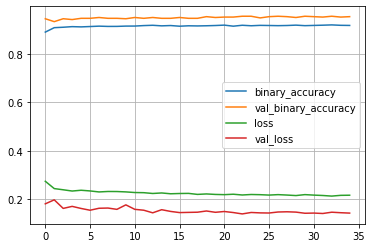

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-04),
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_GRU_1h_Up.h5', monitor='val_binary_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose=0,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
os.chdir(path_models)
#model = load_model('_SBER_LSTM_1h_Up.h5')
model = load_model('_SBER_GRU_1h_Up.h5')

x_test = xTest[-200:]
y_test_org = yTest[-200:]
lstm_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    lstm_test.append('True')
  else:
    lstm_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyLSTM = Counter(lstm_test)
print(accuracyLSTM)

Counter({'True': 191, 'False': 9})


# Моделирование торговли

In [ ]:
from IPython.display import clear_output
from tensorflow.keras.models import load_model

### Функции моделирования торговли и отрисовки графиков

In [ ]:
def trading(model, xTest):
  x_test = xTest
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1000000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    #close = xScaler.inverse_transform(x_test[i])[-3][0] # опрелеяем текущую цену, подаваемую в нейронку
    close = xScaler.inverse_transform(x_test[i])
    #close = close[-1][3]
    close = close[-1][0]

    if statement == 0  and  signal == 1:## ok
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
  

    elif statement == 0  and  signal == 0:## ok
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
      
    elif statement == 1  and  signal == 1:## ok
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue


    elif statement == 1  and  signal == 0:## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      #stock = -capital//close
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue


  #clear_output()
  #returns = returns.append(line, ignore_index=True)
  #print(returns.shape)
  #print(returns)
  return returns


In [ ]:
#xTrain.shape, xScaler.inverse_transform(xTrain[-1])[-1:] # проверка последней подаваемой строки

In [ ]:
def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long) 
  idx_short = np.where(short) 

  plt.figure(figsize=(18,5))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
  plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r', fillstyle='none')
  plt.grid()

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.grid()
  plt.show()

### Моделирование

In [ ]:
#%%timeit
os.chdir(path_models)
file = '_SBER_Conv_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTest)
os.chdir(path_outputs)
returns.to_excel('_SBER_Conv_1h_Up.xlsx')
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
576,1,1,186.08,6024.0,183.88,0.0,0.00,1120945.92,78.58,1121024.50,0.00
577,1,1,185.88,6024.0,183.88,0.0,0.00,1119741.12,78.58,1119819.70,0.00
578,1,0,185.70,0.0,185.70,0.0,204.27,0.00,1118735.38,1118735.38,10963.68
579,0,0,186.15,0.0,0.00,0.0,0.00,0.00,1118735.38,1118735.38,0.00
580,0,0,186.02,0.0,0.00,0.0,0.00,0.00,1118735.38,1118735.38,0.00


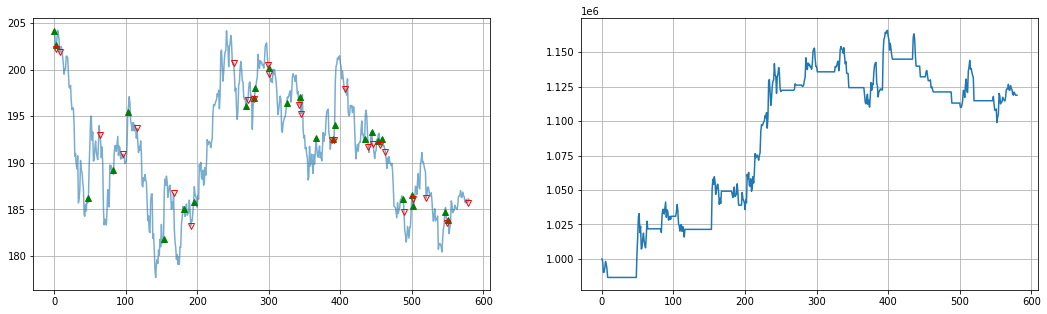

In [ ]:
plotting(returns)

In [ ]:
#%%timeit
os.chdir(path_models)
file = '_SBER_Dense_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTest)
os.chdir(path_outputs)
returns.to_excel('_SBER_Dense_1h_Up.xlsx')
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
576,1,1,186.08,6013.0,183.88,0.0,0.00,1118899.04,48.77,1118947.81,0.00
577,1,1,185.88,6013.0,183.88,0.0,0.00,1117696.44,48.77,1117745.21,0.00
578,1,0,185.70,0.0,185.70,0.0,204.27,0.00,1116662.87,1116662.87,10943.66
579,0,0,186.15,0.0,0.00,0.0,0.00,0.00,1116662.87,1116662.87,0.00
580,0,0,186.02,0.0,0.00,0.0,0.00,0.00,1116662.87,1116662.87,0.00


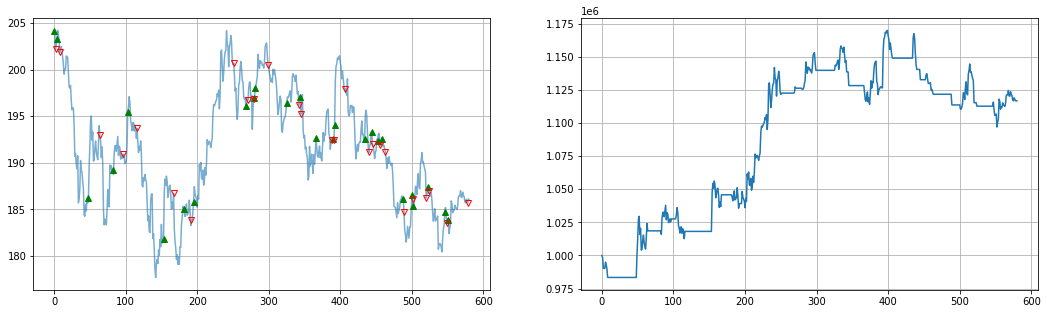

In [ ]:
plotting(returns)

In [ ]:
#%%timeit
os.chdir(path_models)
file = '_SBER_GRU_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTest)
os.chdir(path_outputs)
returns.to_excel('_SBER_GRU_1h_Up.xlsx')
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
576,1,1,186.08,6098.0,183.88,0.0,0.00,1134715.84,74.65,1134790.49,0.00
577,1,1,185.88,6098.0,183.88,0.0,0.00,1133496.24,74.65,1133570.89,0.00
578,1,0,185.70,0.0,185.70,0.0,204.27,0.00,1132473.25,1132473.25,11098.36
579,0,0,186.15,0.0,0.00,0.0,0.00,0.00,1132473.25,1132473.25,0.00
580,0,0,186.02,0.0,0.00,0.0,0.00,0.00,1132473.25,1132473.25,0.00


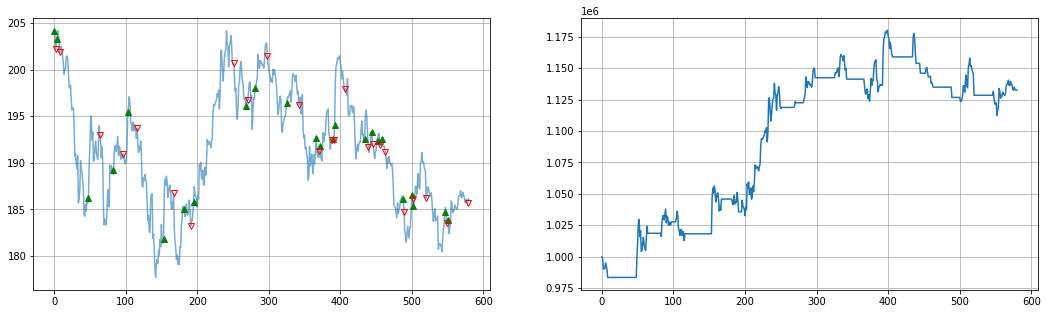

In [ ]:
plotting(returns)

In [ ]:
#%%timeit
os.chdir(path_models)
file = '_SBER_GRU_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTrain[-2500:])
os.chdir(path_outputs)
returns.to_excel('_SBER_GRU_1h_Up.xlsx')
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
2495,0,0,195.33,0.0,0.00,0.000,0.0,0.00,1417131.17,1417131.17,0.0
2496,0,0,195.46,0.0,0.00,0.000,0.0,0.00,1417131.17,1417131.17,0.0
2497,0,0,195.79,0.0,0.00,0.000,0.0,0.00,1417131.17,1417131.17,0.0
2498,0,0,196.34,0.0,0.00,0.000,0.0,0.00,1417131.17,1417131.17,0.0
2499,0,1,198.02,7156.0,198.02,178.218,0.0,1417031.12,100.05,1417131.17,0.0


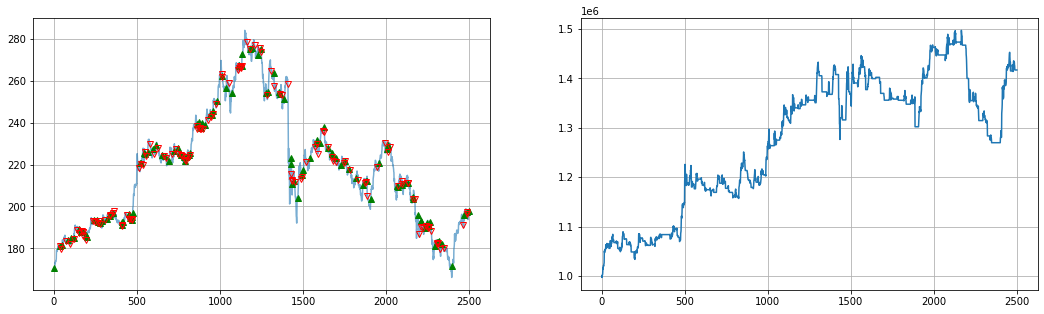

In [ ]:
plotting(returns)